# Import Libraries

In [35]:
import spacy
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import pandas as pd  # Assuming parsed_data is a pandas DataFrame
import networkx as nx


# Load Pretrained Models

In [36]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

# Functions

In [50]:
MAX_TOKEN_LENGTH = 1024

In [51]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"] if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [52]:
# Extract relations from model output
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
    return relations

In [53]:
# Function to chunk text if it exceeds the max token length
def chunk_text(text, max_length=MAX_TOKEN_LENGTH):
    inputs = tokenizer(text, return_tensors="pt", truncation=False)
    token_ids = inputs["input_ids"][0]
    
    # Check if the token length exceeds the model's max token limit
    if len(token_ids) <= max_length:
        return [text]  # No need to chunk if it's within the limit

    # If it exceeds, split the text into smaller chunks
    chunks = []
    chunk_size = max_length - 10  # Reserve some space for any edge cases
    for i in range(0, len(token_ids), chunk_size):
        chunk_ids = token_ids[i:i+chunk_size]
        chunk_text = tokenizer.decode(chunk_ids, skip_special_tokens=True)
        chunks.append(chunk_text)

    return chunks

In [54]:
# Function to extract relations from text using chunking
def from_text_to_kb(text, span_length=128, verbose=False):
    # Chunk the text if necessary
    chunks = chunk_text(text, max_length=MAX_TOKEN_LENGTH)
    
    # Initialize the KB object to store all relations
    kb = KB()

    for chunk in chunks:
        inputs = tokenizer([chunk], return_tensors="pt")

        # Compute span boundaries
        num_tokens = len(inputs["input_ids"][0])
        if verbose:
            print(f"Chunk input has {num_tokens} tokens")
        num_spans = math.ceil(num_tokens / span_length)
        if verbose:
            print(f"Chunk has {num_spans} spans")
        overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
        
        spans_boundaries = []
        start = 0
        for i in range(num_spans):
            spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
            start -= overlap
        if verbose:
            print(f"Span boundaries are {spans_boundaries}")

        # Transform input with spans
        tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

        # Generate relations
        num_return_sequences = 3
        gen_kwargs = {"max_length": 256, "length_penalty": 0, "num_beams": 3, "num_return_sequences": num_return_sequences}
        generated_tokens = model.generate(**inputs, **gen_kwargs)

        # Decode relations
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

        # Add relations to KB
        i = 0
        for sentence_pred in decoded_preds:
            current_span_index = i // num_return_sequences
            relations = extract_relations_from_model_output(sentence_pred)
            for relation in relations:
                relation["meta"] = {"spans": [spans_boundaries[current_span_index]]}
                kb.add_relation(relation)
            i += 1

    return kb

In [55]:
# Build knowledge graph from KB
def build_knowledge_graph_from_kb(kb):
    G = nx.Graph()

    # Add relations to the graph
    for relation in kb.relations:
        head = relation['head']
        tail = relation['tail']
        rel_type = relation['type']
        G.add_edge(head, tail, label=rel_type)

    return G

In [56]:
# Visualize the knowledge graph
def visualize_knowledge_graph(G):
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'label')
    
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=15, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
    plt.show()

In [57]:
# Process each passage in the DataFrame and build the overall knowledge graph
def process_dataframe_and_build_kg(df):
    # Initialize an empty KB to store all relations
    combined_kb = KB()

    # Iterate over each passage in the DataFrame
    for ind, row in df.iterrows():
        text = row['passage_text']  # Extract the text of each passage

        # Extract KB for this specific passage
        passage_kb = from_text_to_kb(text)

        # Add all relations from this passage into the combined KB
        for relation in passage_kb.relations:
            combined_kb.add_relation(relation)

    # Build the knowledge graph from the combined KB
    G = build_knowledge_graph_from_kb(combined_kb)

    # Visualize the final knowledge graph
    visualize_knowledge_graph(G)

    return G

# Data Processing

In [ ]:
INPUT_DATASET = "Milestone_1/GraphRAG/input/dataset0.txt"

import re
import pandas as pd

# Function to parse the text dataset
def parse_dataset(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
    
    records = content.split("----------")
    
    dataset = []
    
    query_pattern = re.compile(r"Query:\s*(.*)")
    query_id_pattern = re.compile(r"Query_id:\s*(\d+)")
    query_type_pattern = re.compile(r"Query_type:\s*(\w+)")
    answers_pattern = re.compile(r"Answers:\s*(.*)")
    passage_text_pattern = re.compile(r"passage_text:\s*(.*?)(?:url:|$)", re.DOTALL)
    url_pattern = re.compile(r"url:\s*(.*)", re.DOTALL)
    
    for record in records:
        record = record.strip()
        if not record:
            continue
        
        query_match = query_pattern.search(record)
        query_id_match = query_id_pattern.search(record)
        query_type_match = query_type_pattern.search(record)
        answers_match = answers_pattern.search(record)
        passage_text_match = passage_text_pattern.search(record)
        url_match = url_pattern.search(record)
        
        entry = {
            "Query": query_match.group(1).strip() if query_match else None,
            "Query_id": query_id_match.group(1).strip() if query_id_match else None,
            "Query_type": query_type_match.group(1).strip() if query_type_match else None,
            "Answers": answers_match.group(1).strip() if answers_match else None,
            "passage_text": passage_text_match.group(1).strip() if passage_text_match else None,
            "url": url_match.group(1).strip() if url_match else None
        }
        
        dataset.append(entry)
    
    return dataset

parsed_data = parse_dataset(INPUT_DATASET)
parsed_data = pd.DataFrame(parsed_data)
parsed_data.to_csv("dataset.csv", index=False)

# Construct KG

In [58]:
df = pd.read_csv("dataset.csv")

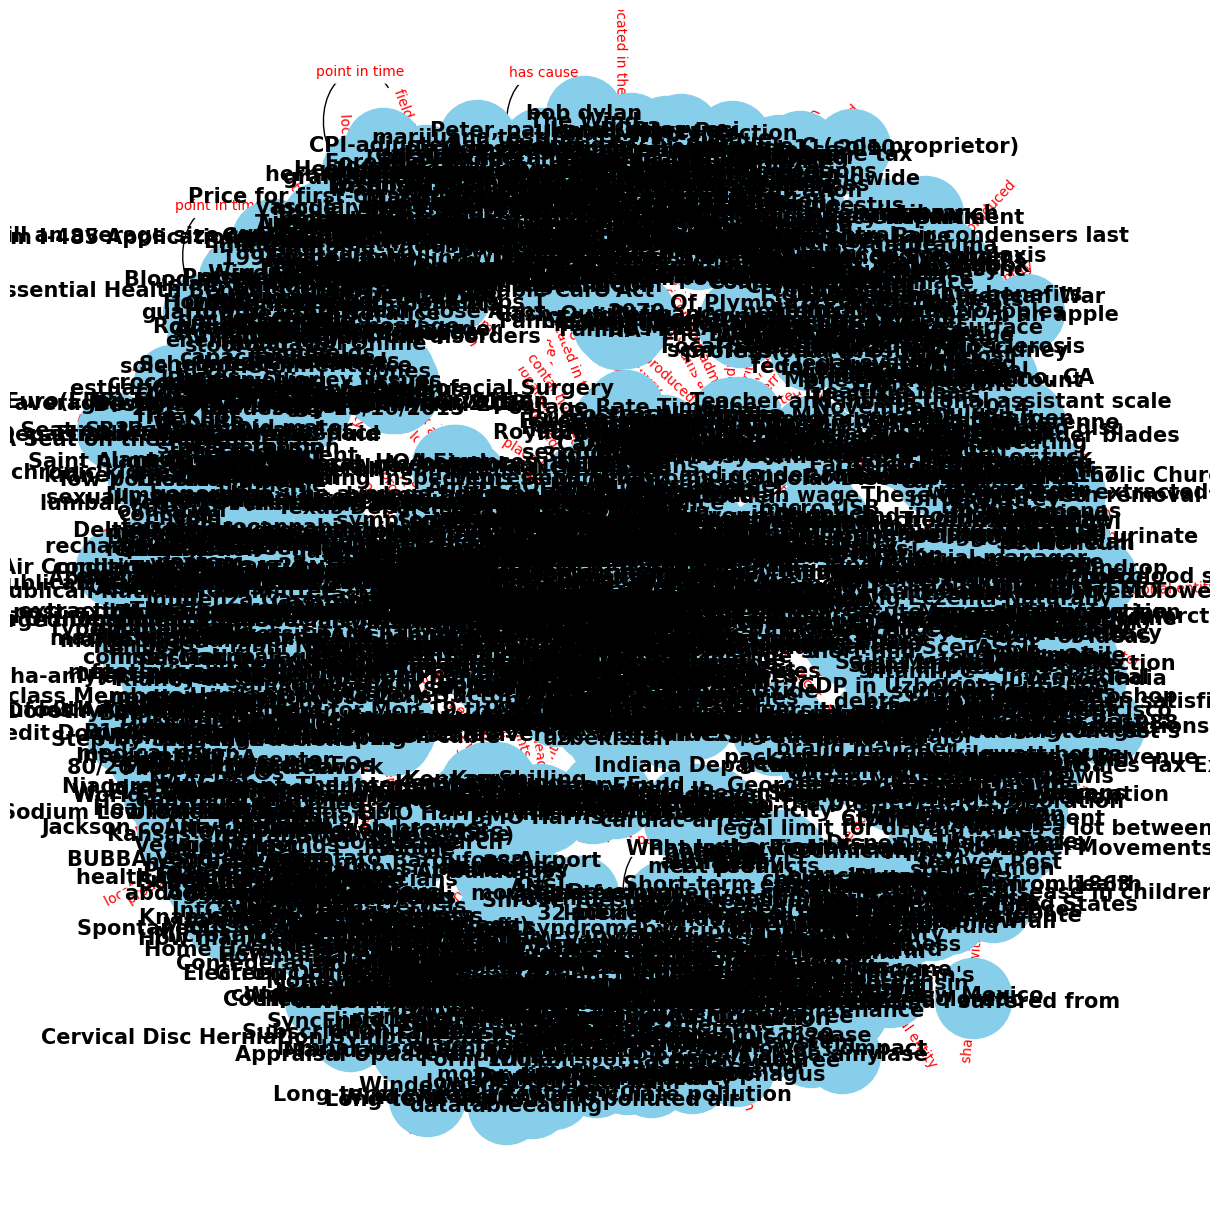

In [59]:
G = process_dataframe_and_build_kg(df)


In [60]:
nx.write_graphml(G, "knowledge_graph.graphml")